In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations
from scipy.stats import friedmanchisquare

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

from _cd_diagram import draw_cd_diagram

# Getting some free samples
results_df.sample(3)

# Don't change any code below, it may break (probably will) --------------------



['../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDownOnlyLast.py', '../models/SimplifierTopDown1e-0.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown1e-6.py', '../models/Vanilla.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp.py'] ['Top Down 1e-1', 'Bottom Up (only last)', 'Top Down (only last)', 'Top Down 1e-0', 'Top Down 1e-4', 'Top Down 1e-6', 'Without simplify', 'Top Down', 'Top Down 1e-10', 'Top Down 1e-2', 'Bottom Up']
(236, 14)
['Without simplify' 'Top Down' 'Bottom Up']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Yacht']


,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth
100,Bottom Up,Energy Cooling,0,27690,647.084922,01-18-2024 15:11:27,0.879291,0.888491,9.868628,9.186503,"add(mul3(x_4, add4(108.97598886766245, add4(x_2, x_3, log1p(x_6), multiply(x_6, 337.8837987094369)), x_4, x_4), 0.00809328832033131), -4.481199869850676)",17,5944,5
204,Without simplify,Yacht,0,16695,179.576125,01-18-2024 15:03:34,0.992421,0.989023,1.732217,2.669039,"add(-1.814004737642619, subtract(exp(multiply(21.26227156953563, multiply(x_5, x_5))), mul4(log1p(0.0032601300363681116), x_4, exp(multiply(17.935301834527827, x_5)), mul4(x_1, x_3, x_5, x_1))))",22,1206,5
127,Top Down,Energy Heating,0,27690,609.251300,01-18-2024 15:16:11,0.923382,0.929402,7.100389,6.848460,"subtract(mul3(tan(x_4), x_2, 0.07563808378685116), mul3(-3.0845153756056147, x_4, sqrtabs(x_6)))",11,90,3


criteria         Harmonic Mean size mean score                      \
                          mean              lb      mean        ub   
model                                                                
Without simplify      1.969716        1.520351  1.745455  1.970558   
Top Down              1.841437        1.829693  1.995139  2.160584   
Bottom Up             1.795448        1.600379  1.826263  2.052146   

criteria         test_mse mean score                      
                                  lb      mean        ub  
model                                                     
Without simplify            1.897009  2.260101  2.623193  
Top Down                    1.440337  1.709722  1.979107  
Bottom Up                   1.578425  1.765657  1.952888

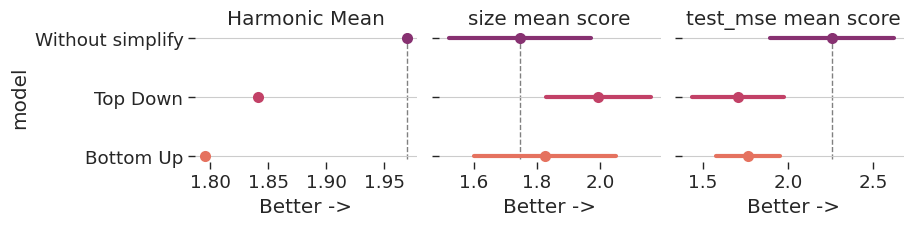

criteria         Harmonic Mean complexity mean score                      \
                          mean                    lb      mean        ub   
model                                                                      
Top Down              1.906767              1.712762  1.886111  2.059460   
Bottom Up             1.846237              1.639490  1.952020  2.264551   
Without simplify      1.757635              1.467339  1.709091  1.950842   

criteria         depth mean score                     size mean score  \
                               lb      mean        ub              lb   
model                                                                   
Top Down                 1.778069  1.986111  2.194153        1.829693   
Bottom Up                1.637069  1.839394  2.041719        1.600379   
Without simplify         1.514960  1.663384  1.811807        1.520351   

criteria                             test_mse mean score                      \
                      mean        ub                  lb      mean        ub   
model                                                                          
Top Down          1.995139  2.160584            1.440337  1.709722  1.979107   
Bottom Up         1.826263  2.052146            1.578425  1.765657  1.952888   
Without simplify  1.745455  1.970558            1.897009  2.260101  2.623193   

criteria         test_r2 mean score                      
                                 lb      mean        ub  
model                                                    
Top Down                   1.787309  1.990278  2.193247  
Bottom Up                  1.622497  1.857576  2.092654  
Without simplify           1.265722  1.555051  1.844379

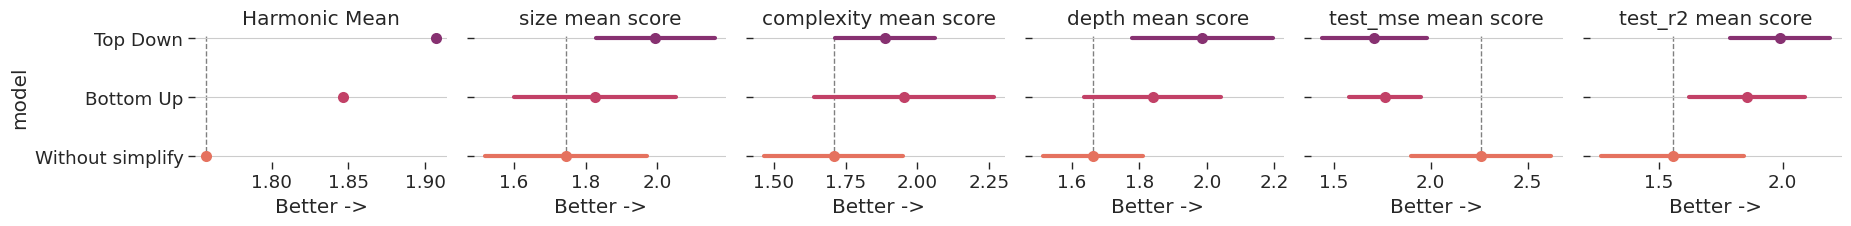

criteria         Harmonic Mean complexity mean score                      \
                          mean                    lb      mean        ub   
model                                                                      
Top Down              1.906767              1.712762  1.886111  2.059460   
Bottom Up             1.846237              1.639490  1.952020  2.264551   
Without simplify      1.757635              1.467339  1.709091  1.950842   

criteria         depth mean score                     size mean score  \
                               lb      mean        ub              lb   
model                                                                   
Top Down                 1.778069  1.986111  2.194153        1.829693   
Bottom Up                1.637069  1.839394  2.041719        1.600379   
Without simplify         1.514960  1.663384  1.811807        1.520351   

criteria                             test_mse mean score                      \
                      mean        ub                  lb      mean        ub   
model                                                                          
Top Down          1.995139  2.160584            1.440337  1.709722  1.979107   
Bottom Up         1.826263  2.052146            1.578425  1.765657  1.952888   
Without simplify  1.745455  1.970558            1.897009  2.260101  2.623193   

criteria         test_r2 mean score                      
                                 lb      mean        ub  
model                                                    
Top Down                   1.787309  1.990278  2.193247  
Bottom Up                  1.622497  1.857576  2.092654  
Without simplify           1.265722  1.555051  1.844379

In [2]:
def plot_rankings(columns, results_df, path):
    ranks_data = []
    for col in columns:
        ranks_df = results_df.pivot( # Smaller is better for all columns here
            index=['dataset', 'RunID', 'random_state'], columns='model', values=col
        ).rank(ascending=False, axis=1).groupby('dataset').mean()#.rank(ascending=False, axis=1)
        
        for model in results_df['model'].unique():
            df_model = ranks_df[ model ]
            values = df_model.values

            # Estimating lower and upper confidence bounds
            lb, ub = stats.norm.interval(confidence=0.95, loc=np.mean(values),
                                        scale=stats.sem(values))
            lb = np.nan_to_num(lb, 0.0)
            ub = np.nan_to_num(ub, 0.0)

            ranks_data.append( (model, f'{col} mean score', df_model.mean(), lb, ub) )

    # Creating the dataframe
    ranks_data_df = pd.DataFrame(data=ranks_data,
                                columns=['model', 'criteria', 'mean', 'lb', 'ub'])

    ranks_data_df = ranks_data_df.pivot(columns='criteria', index='model')

    # will calculate the harmonic mean and plot the columns based on mean rankings
    ranks_data_df[('mean', 'Harmonic Mean')] = (
        ranks_data_df[[('mean', f'{col} mean score') for col in columns]]
    )['mean'].apply(stats.hmean, axis=1)

    ranks_data_df = ranks_data_df.sort_values(by=('mean', 'Harmonic Mean'), ascending=False)
    ranks_data_df = ranks_data_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

    display(ranks_data_df)
    #print(ranks_data_df.to_latex())

    # Use semantically meaningful titles for the columns
    titles = ['Harmonic Mean']+[f'{col} mean score' for col in columns]

    # Now making the plot
    g = sns.PairGrid(ranks_data_df.reorder_levels([1, 0], axis=1)['mean'].reset_index(),
                    x_vars=titles, y_vars=['model'], height=2.5, aspect=1.25)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=8, orient="h", jitter=False,
        palette="flare_r", linewidth=0, edgecolor="w")

    # setting the reference as the Baseline 
    unif = ((ranks_data_df[ ranks_data_df.index=='Without simplify'])['Harmonic Mean'])['mean'].values[0]
    g.axes.flat[0].axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

    g.axes.flat[0].set(title='Harmonic Mean')
    g.axes.flat[0].set_xlabel('Better ->')
    #g.axes.flat[0].set_xlim( (-1, len(ranks_data_df.index)+1) )

    # Make the grid horizontal instead of vertical
    g.axes.flat[0].xaxis.grid(False)
    g.axes.flat[0].yaxis.grid(True)

    for ax, title in zip(g.axes.flat[1:], titles[1:]):
        color = iter(sns.color_palette("flare_r", ranks_data_df.shape[0]))
        for tick, text in zip(g.axes.flat[0].get_yticks(), g.axes.flat[0].get_yticklabels()):
            c=next(color)
            sample_name = text.get_text()  # "X" or "Y"
            single_df = ranks_data_df[ ranks_data_df.index==sample_name ]
            
            lb, ub, mean_val = (single_df[title])[ ['lb', 'ub', 'mean'] ].values[0]
            rank_val = ranks_data_df.reset_index()[(ranks_data_df.reset_index()['model']==sample_name)].index

            # plot horizontal lines across the column, centered on the tCIk
            ax.plot([lb, ub], [rank_val, rank_val], lw=3, color=c)

        # Draw a reference line on baseline
        unif = (ranks_data_df[ ranks_data_df.index=='Without simplify'])[(title, 'mean')].values[0]
        ax.axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

        # Set a different title for each axes
        ax.set(title=title)
        ax.set_xlabel('Better ->')
        #ax.set_xlim( (-1, len(ranks_data_df.index)+1) )

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.savefig(f'{path}.pdf')
    plt.savefig(f'{path}.png', dpi=600)

    plt.show()

    return ranks_data_df

plot_rankings(['size', 'test_mse'], results_df, "../paper/figs/size_mse")
plot_rankings(['size', 'complexity', 'depth', 'test_mse', 'test_r2'], results_df, "../paper/figs/size_mse_compexity_depth")
